URL: https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/04-evaluation/homework.md

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("Datasets/AER_credit_card_data.csv")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.card = (df.card == 'yes').astype('int')

In [6]:
df.card.head()

0    1
1    1
2    1
3    1
4    1
Name: card, dtype: int32

In [17]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Question 1

In [14]:
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
numerical_columns.remove('card')

In [15]:
numerical_columns

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [18]:
y_train = df_train.card.values
del df_train['card']

reports : 0.28333701393106236
age : 0.4759979020592945
income : 0.5908049467233478
share : 0.989183643423692
expenditure : 0.991042345276873
dependents : 0.46722427722262094
months : 0.470578221903237
majorcards : 0.5343859842838476
active : 0.6043173411362006


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

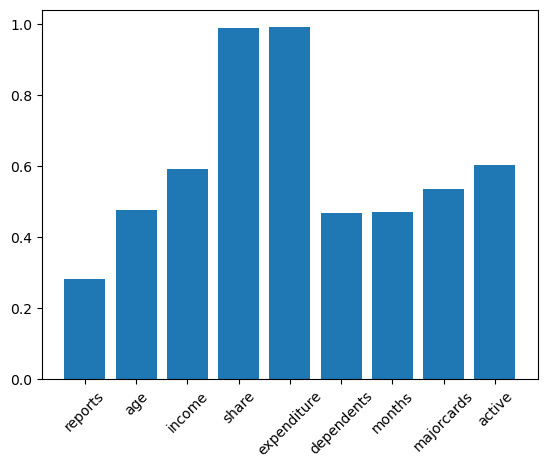

In [22]:
from sklearn.metrics import roc_auc_score

scores = []
for column in numerical_columns:
    y = df_train[column].values
    score = roc_auc_score(y_train, y)
    if score < 0.5:
        y = -df_train[column].values
        roc_auc_score(y_train, y)
    scores.append(score)
    print(column, ':', score)
    
plt.bar(numerical_columns, scores)
plt.xticks(rotation=45)

### Answer: share

# Question 2

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [67]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [27]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [32]:
val_dict = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val.card
y_pred = model.predict_proba(X_val)[:, 1]

In [33]:
def roc_auc_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for threshold in thresholds:
        scores.append((threshold, roc_auc_score(y_val, y_pred)))
        
    columns = ['threshold', 'auc_score']
    scores_df = pd.DataFrame(scores, columns = columns)

    return scores_df

In [34]:
df_scores = roc_auc_dataframe(y_val, y_pred)
df_scores.head()

,threshold,auc_score
0,0.00,0.995171
1,0.01,0.995171
2,0.02,0.995171
3,0.03,0.995171
4,0.04,0.995171


In [36]:
round(np.mean(df_scores.auc_score.values), 3)

0.995

### Answer : 0.995

# Question 3

In [38]:
def pre_recall_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for threshold in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predict_positive = (y_pred >= threshold)
        predict_negative = (y_pred < threshold)
        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((threshold, tp, tn, fp, fn))
        
    columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
    scores_df = pd.DataFrame(scores, columns = columns)
    
    scores_df['precision'] = scores_df.tp / (scores_df.tp + scores_df.fp)
    scores_df['recall'] = scores_df.tp / (scores_df.tp + scores_df.fn)

    return scores_df

In [39]:
df_scores_pre_recall = pre_recall_dataframe(y_val, y_pred)
df_scores_pre_recall.head()

,threshold,tp,tn,fp,fn,precision,recall
0,0.00,211,0,53,0,0.799242,1.0
1,0.01,211,19,34,0,0.861224,1.0
2,0.02,211,22,31,0,0.871901,1.0
3,0.03,211,29,24,0,0.897872,1.0
4,0.04,211,31,22,0,0.905579,1.0


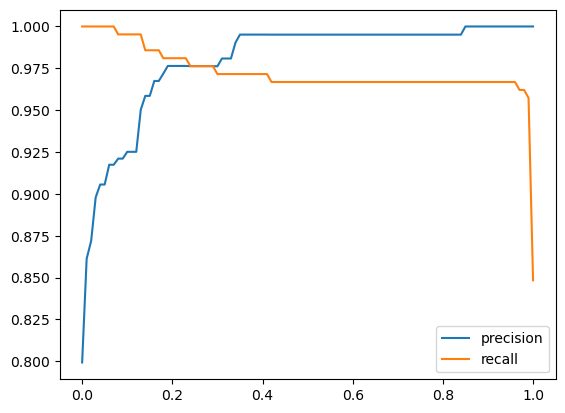

In [40]:
plt.plot(df_scores_pre_recall.threshold, df_scores_pre_recall.precision, label = 'precision')
plt.plot(df_scores_pre_recall.threshold, df_scores_pre_recall.recall, label = 'recall')
plt.legend()

### Answer : 0.3

# Question 4

In [41]:
df_scores_pre_recall['f1_score'] = 2 * df_scores_pre_recall.precision * df_scores_pre_recall.recall/(df_scores_pre_recall.precision+df_scores_pre_recall.recall)
df_scores_pre_recall.head()

,threshold,tp,tn,fp,fn,precision,recall,f1_score
0,0.00,211,0,53,0,0.799242,1.0,0.888421
1,0.01,211,19,34,0,0.861224,1.0,0.925439
2,0.02,211,22,31,0,0.871901,1.0,0.931567
3,0.03,211,29,24,0,0.897872,1.0,0.946188
4,0.04,211,31,22,0,0.905579,1.0,0.950450


In [43]:
df_scores_pre_recall[df_scores_pre_recall.f1_score == df_scores_pre_recall.f1_score.max()]

,threshold,tp,tn,fp,fn,precision,recall,f1_score
35,0.35,205,52,1,6,0.995146,0.971564,0.983213
36,0.36,205,52,1,6,0.995146,0.971564,0.983213
37,0.37,205,52,1,6,0.995146,0.971564,0.983213
38,0.38,205,52,1,6,0.995146,0.971564,0.983213
39,0.39,205,52,1,6,0.995146,0.971564,0.983213
40,0.40,205,52,1,6,0.995146,0.971564,0.983213
41,0.41,205,52,1,6,0.995146,0.971564,0.983213


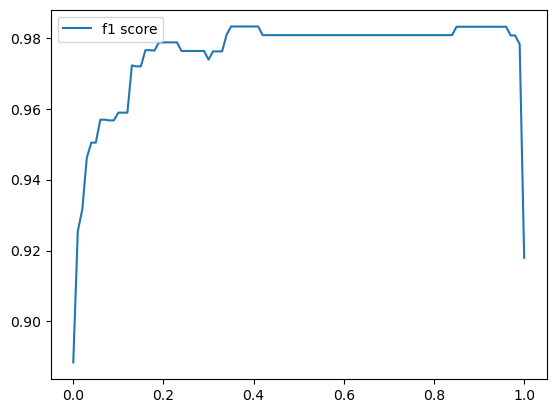

In [44]:
plt.plot(df_scores_pre_recall.threshold, df_scores_pre_recall.f1_score, label = 'f1 score')
plt.legend()

### Answer 0.4

# Question 5

In [51]:
!pip install tqdm

     -------------------------------------- 78.5/78.5 kB 291.6 kB/s eta 0:00:00


In [52]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [53]:
def train(df, columns, y_train, C=1.0):
    dicts = df[columns].to_dict(orient='records')
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [54]:
def predict(df, dv, model, columns):
    dicts = df[columns].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [56]:
from tqdm.auto import tqdm
auc_scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, columns, y_train)
    y_pred = predict(df_val, dv, model, columns)
    
    
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

0it [00:00, ?it/s]

In [60]:
round(np.mean(auc_scores), 3), round(np.std(auc_scores), 3)

(0.996, 0.003)

### Answer: 0.003

# Question 6

In [68]:
c_scores = []

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, columns, y_train, C)
        y_pred = predict(df_val, dv, model, columns)


        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)
    c_scores.append((C, round(np.mean(auc_scores), 3), round(np.std(auc_scores), 3)))
    
c_scores_columns = ['C', 'AUC_mean', 'AUC_std']
df_c_scores = pd.DataFrame(c_scores, columns = c_scores_columns)
df_c_scores

  0%|          | 0/4 [00:00<?, ?it/s]

,C,AUC_mean,AUC_std
0,0.01,0.992,0.006
1,0.10,0.995,0.004
2,1.00,0.996,0.003
3,10.00,0.996,0.003


### Answer: 1